# Text Summerization - Encoder Decoder with Attention Mechanism

### Importing Basic libraries

In [ ]:
!wget 'http://nlp.stanford.edu/data/glove.42B.300d.zip'
!unzip '/content/glove.42B.300d.zip'

--2021-08-17 15:39:21--  http://nlp.stanford.edu/data/glove.42B.300d.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.42B.300d.zip [following]
--2021-08-17 15:39:21--  https://nlp.stanford.edu/data/glove.42B.300d.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.42B.300d.zip [following]
--2021-08-17 15:39:21--  http://downloads.cs.stanford.edu/nlp/data/glove.42B.300d.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1877800501 (1.7G) [application/zip]
Sav

In [ ]:
pip install contractions

     |████████████████████████████████| 321 kB 7.3 MB/s 
     |████████████████████████████████| 283 kB 57.9 MB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.2-cp37-cp37m-linux_x86_64.whl size=85455 sha256=a96de15d9ecca976f7f68e2f09923d137650b75e2d5cbf2f77be9fa0c74ac6e5
  Stored in directory: /root/.cache/pip/wheels/25/19/a6/8f363d9939162782bb8439d886469756271abc01f76fbd790f
Successfully built pyahocorasick


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.activity.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fexperimentsandconfigs%20https%3a%2f%2fwww.googleapis.com%2fauth%2fphotos.native&response_type=code

Enter your authorization code:
4/1AX4XfWiyPJQyqU0BHS58Pi_y4LqymjVA2RJXFlZLKhWF_afDtQkFNtRDGbU
Mounted at /content/drive


In [ ]:
import re
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import contractions
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from keras import backend as K 
from tensorflow.python.keras.layers import Layer


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
!cp /content/drive/MyDrive/news_summary_more.csv /content

### Importing Data

In [ ]:
data_path = '/content/news_summary_more.csv'
data = pd.read_csv(data_path)
data.head()

,headlines,text
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's..."
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer..."
4,"Have known Hirani for yrs, what if MeToo claim...",Speaking about the sexual harassment allegatio...


In [ ]:
data.drop_duplicates(subset=['headlines'],inplace=True)
data.reset_index(inplace=True, drop=True)

In [ ]:
stop_words = stopwords.words('english')

def preprocess(text):
    text = text.lower()
    text = ' '.join([contractions.fix(word) for word in text.split(" ")])    
    
    tokens = [w for w in text.split() if not w in stop_words]
    text = " ".join(tokens)
    text = text.replace("'s",'')
    text = text.replace(".",'')
    text = re.sub(r'\(.*\)','',text)
    text = re.sub(r'[^a-zA-Z0-9. ]',' ',text)
    text = re.sub(r'\.','. ',text)
    text = re.sub(r'\s+', ' ', text)
    return text


In [ ]:
data['headlines'] = data['headlines'].apply(preprocess)
data['text'] = data['text'].apply(preprocess)
data['headlines'] = data['headlines'].apply(lambda x : '_START_ '+ x + ' _END_')

for i in range(2):
    print('Summary:', data['headlines'][i],'Text:', data['text'][i], sep='\n')
    print()

Summary:
_START_ upgrad learner switches career ml al 90 salary hike _END_
Text:
saurav kant alumnus upgrad iiit b pg program machine learning artificial intelligence sr systems engineer infosys almost 5 years work experience program upgrad 360 degree career support helped transition data scientist tech mahindra 90 salary hike upgrad online power learning powered 3 lakh careers

Summary:
_START_ delhi techie wins free food swiggy one year cred _END_
Text:
kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending 2000 cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cultfit more



In [ ]:
headlines_length = [len(x.split()) for x in data.headlines]
text_length = [len(x.split()) for x in data.text]

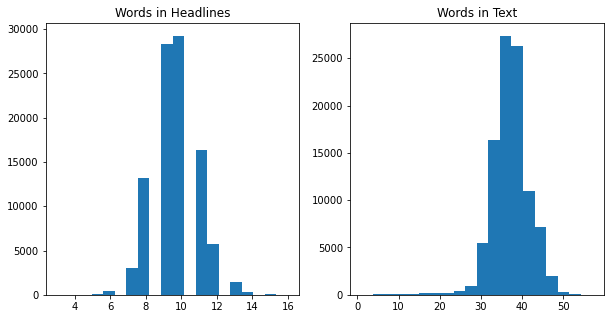

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (10,5))
ax1.hist(headlines_length, bins = 20)
ax2.hist(text_length, bins = 20)

ax1.title.set_text("Words in Headlines")
ax2.title.set_text("Words in Text")
plt.show()

### Embedding Matrix from Glove


In [ ]:
glove_size = 300
f = open('/content/glove.42B.300d.txt')

In [ ]:
embeddings_index = dict()
for line in f:
	values = line.split()
	embeddings_index[values[0]] = np.asarray(values[1:], dtype='float32')
f.close()

In [ ]:
words_source_train = []
for i in data['text'] :
  words_source_train.extend(i.split(' '))

print("all the words in the corpus", len(words_source_train))
words_source_train = set(words_source_train)
print("the unique words in the corpus", len(words_source_train))
inter_words = set(embeddings_index.keys()).intersection(words_source_train)
print("The number of words that are present in both glove vectors and our corpus are {} which \
is nearly {}% ".format(len(inter_words), np.round((float(len(inter_words))/len(words_source_train))
*100)))

words_corpus_source_train = {}
words_glove = set(embeddings_index.keys())
for i in words_source_train:
  if i in words_glove:
    words_corpus_source_train[i] = embeddings_index[i]
print("word 2 vec length", len(words_corpus_source_train))

all the words in the corpus 3665888
the unique words in the corpus 90013
The number of words that are present in both glove vectors and our corpus are 70834 which is nearly 79.0% 
word 2 vec length 70834


In [ ]:
def num(text):
  words = [w for w in text.split() if not w in inter_words]
  return len(words)

data['unique_words'] = data['text'].apply(num)

In [ ]:
data = data[data['unique_words'] < 4]
data.reset_index(inplace=True, drop=True)

In [ ]:
data

,headlines,text,unique_words
0,_START_ upgrad learner switches career ml al 9...,saurav kant alumnus upgrad iiit b pg program m...,0
1,_START_ delhi techie wins free food swiggy one...,kunal shah credit card bill payment platform c...,2
2,_START_ new zealand end rohit sharma led india...,new zealand defeated india 8 wickets fourth od...,0
3,_START_ aegon life iterm insurance plan helps ...,aegon life iterm insurance plan customers enjo...,0
4,_START_ known hirani yrs metoo claims true son...,speaking sexual harassment allegations rajkuma...,1
...,...,...,...
97351,_START_ crpf jawan axed death maoists chhattis...,crpf jawan tuesday axed death sharp edged weap...,0
97352,_START_ first song sonakshi sinha noor titled ...,uff yeh first song sonakshi sinha starrer upc...,2
97353,_START_ the matrix film get reboot reports _END_,according reports new version 1999 science fic...,0
97354,_START_ snoop dogg aims gun clown dressed trum...,new music video shows rapper snoop dogg aiming...,0


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(data['text'], data['headlines'], test_size = 0.2, random_state = 20)
X_test, X_val, y_test, y_val = train_test_split(X_val, y_val, test_size = 0.5, random_state = 20)

In [ ]:
max_length_x = max(text_length)
max_length_y = max(headlines_length)

In [ ]:
x_t = Tokenizer()
x_t.fit_on_texts(data['text'] + data['headlines'])
x_vocab_size = len(x_t.word_index) + 1

encoded_xtrain = x_t.texts_to_sequences(X_train)
encoded_xval = x_t.texts_to_sequences(X_val)
encoded_xtest = x_t.texts_to_sequences(X_test)

padded_xtrain = pad_sequences(encoded_xtrain, maxlen=max_length_x, padding='post')
padded_xval = pad_sequences(encoded_xval, maxlen=max_length_x, padding='post')
padded_xtest = pad_sequences(encoded_xtest, maxlen=max_length_x, padding='post')

In [ ]:
y_t = Tokenizer()
y_t.fit_on_texts(data['headlines'])
y_vocab_size = len(y_t.word_index) + 1

encoded_ytrain = y_t.texts_to_sequences(y_train)
encoded_yval = y_t.texts_to_sequences(y_val)
encoded_ytest = y_t.texts_to_sequences(y_test)

padded_ytrain = pad_sequences(encoded_ytrain, maxlen=max_length_y, padding='post')
padded_yval = pad_sequences(encoded_yval, maxlen=max_length_y, padding='post')
padded_ytest = pad_sequences(encoded_ytest, maxlen=max_length_y, padding='post')

In [ ]:
print('Loaded %s word vectors.' % len(embeddings_index))

embedding_matrix = np.zeros((x_vocab_size, glove_size))
for word, i in x_t.word_index.items():
	embedding_vector = embeddings_index.get(word)
	if embedding_vector is not None:
		embedding_matrix[i] = embedding_vector

Loaded 1917494 word vectors.


### Building Model

In [ ]:
class AttentionLayer(Layer):

    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):

        self.W_a = self.add_weight(name='W_a',
                                   shape=tf.TensorShape((input_shape[0][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.U_a = self.add_weight(name='U_a',
                                   shape=tf.TensorShape((input_shape[1][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.V_a = self.add_weight(name='V_a',
                                   shape=tf.TensorShape((input_shape[0][2], 1)),
                                   initializer='uniform',
                                   trainable=True)

        super(AttentionLayer, self).build(input_shape)

    def call(self, inputs):
        encoder_out_seq, decoder_out_seq = inputs

        def energy_step(inputs, states):
          
            en_seq_len, en_hidden = encoder_out_seq.shape[1], encoder_out_seq.shape[2]
            de_hidden = inputs.shape[-1]

            reshaped_enc_outputs = K.reshape(encoder_out_seq, (-1, en_hidden))
            W_a_dot_s = K.reshape(K.dot(reshaped_enc_outputs, self.W_a), (-1, en_seq_len, en_hidden))
            U_a_dot_h = K.expand_dims(K.dot(inputs, self.U_a), 1)  
            
            reshaped_Ws_plus_Uh = K.tanh(K.reshape(W_a_dot_s + U_a_dot_h, (-1, en_hidden)))
            e_i = K.reshape(K.dot(reshaped_Ws_plus_Uh, self.V_a), (-1, en_seq_len))
            e_i = K.softmax(e_i)

            return e_i, [e_i]

        def context_step(inputs, states):
            c_i = K.sum(encoder_out_seq * K.expand_dims(inputs, -1), axis=1)
            return c_i, [c_i]

        def create_inital_state(inputs, hidden_size):
            
            fake_state = K.zeros_like(inputs)  
            fake_state = K.sum(fake_state, axis=[1, 2])  
            fake_state = K.expand_dims(fake_state)  
            fake_state = K.tile(fake_state, [1, hidden_size])  
            return fake_state

        fake_state_c = create_inital_state(encoder_out_seq, encoder_out_seq.shape[-1])
        fake_state_e = create_inital_state(encoder_out_seq, encoder_out_seq.shape[1])  

        last_out, e_outputs, _ = K.rnn(
            energy_step, decoder_out_seq, [fake_state_e],
        )

        last_out, c_outputs, _ = K.rnn(
            context_step, e_outputs, [fake_state_c],
        )
        return c_outputs, e_outputs

    def compute_output_shape(self, input_shape):
        return [
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[1][2])),
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[0][1]))
        ]


In [ ]:
latent_dim=500

K.clear_session() 

encoder_inputs = Input(shape=(max_length_x,)) 
enc_emb = Embedding(x_vocab_size, glove_size, weights=[embedding_matrix],input_length=max_length_x, trainable=False)(encoder_inputs) 

#LSTM 
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True) 
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb) 
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True) 
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1) 
encoder_lstm3 = LSTM(latent_dim, return_state=True, return_sequences=True) 
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2) 

# Decoder. 
decoder_inputs = Input(shape=(None,)) 
dec_emb_layer = Embedding(x_vocab_size, glove_size, weights=[embedding_matrix],input_length=max_length_x, trainable=False) 
dec_emb = dec_emb_layer(decoder_inputs) 

#LSTM using encoder_states as initial state
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True) 
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c]) 

#Attention Layer
attn_layer = AttentionLayer(name='attention_layer') 
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs]) 

decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])
decoder_dense = TimeDistributed(Dense(y_vocab_size, activation='softmax')) 
decoder_outputs = decoder_dense(decoder_concat_input) 

model = Model([encoder_inputs, decoder_inputs], decoder_outputs) 
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 57)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 57, 300)      26975700    input_5[0][0]                    
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 57, 500), (N 1602000     embedding[0][0]                  
______________________________________________________________________________________________

In [ ]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')
checkpoint_filepath = '/content/model.{epoch:02d}-{val_loss:.2f}.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,save_weights_only=True,monitor='val_loss',mode='min',save_best_only=True, save_freq = "epoch")
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
history=model.fit([padded_xtrain,padded_ytrain[:,:-1]], padded_ytrain.reshape(padded_ytrain.shape[0],padded_ytrain.shape[1], 1)[:,1:] ,epochs=30,batch_size=512, validation_data=([padded_xval,padded_yval[:,:-1]], padded_yval.reshape(padded_yval.shape[0],padded_yval.shape[1], 1)[:,1:]), callbacks=[es, model_checkpoint_callback])

Epoch 1/30
153/153 [==============================] - 188s 1s/step - loss: 4.7862 - val_loss: 4.4794
Epoch 2/30
153/153 [==============================] - 184s 1s/step - loss: 4.1536 - val_loss: 3.9571
Epoch 3/30
153/153 [==============================] - 184s 1s/step - loss: 3.6652 - val_loss: 3.6310
Epoch 4/30
153/153 [==============================] - 185s 1s/step - loss: 3.2448 - val_loss: 3.4038
Epoch 5/30
153/153 [==============================] - 185s 1s/step - loss: 2.8660 - val_loss: 3.2693
Epoch 6/30
153/153 [==============================] - 185s 1s/step - loss: 2.5345 - val_loss: 3.1968
Epoch 7/30
153/153 [==============================] - 185s 1s/step - loss: 2.2526 - val_loss: 3.1502
Epoch 8/30
153/153 [==============================] - 184s 1s/step - loss: 2.0222 - val_loss: 3.1206
Epoch 9/30
153/153 [==============================] - 185s 1s/step - loss: 1.8260 - val_loss: 3.1093
Epoch 10/30
153/153 [==============================] - 184s 1s/step - loss: 1.6569 - val_lo

In [ ]:
model1 = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model1.load_weights("model.h5")
model1.compile(optimizer='adam', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
history=model1.fit([padded_xtrain,padded_ytrain[:,:-1]], padded_ytrain.reshape(padded_ytrain.shape[0],padded_ytrain.shape[1], 1)[:,1:] ,epochs=30,batch_size=512, validation_data=([padded_xval,padded_yval[:,:-1]], padded_yval.reshape(padded_yval.shape[0],padded_yval.shape[1], 1)[:,1:]), callbacks=es)

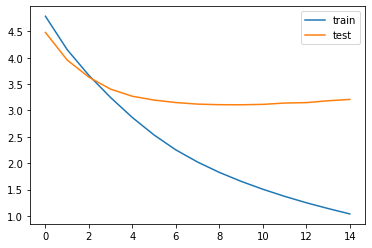

In [ ]:
from matplotlib import pyplot 
pyplot.plot(history.history['loss'], label='train') 
pyplot.plot(history.history['val_loss'], label='test') 
pyplot.legend() 
pyplot.show()

### Inference

In [ ]:
reverse_target_word_index = y_t.index_word 
reverse_source_word_index = x_t.index_word 
target_word_index = y_t.word_index

In [ ]:
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_length_x,latent_dim))

dec_emb2= dec_emb_layer(decoder_inputs)
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

decoder_outputs2 = decoder_dense(decoder_inf_concat)

decoder_model = Model(
[decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
[decoder_outputs2] + [state_h2, state_c2])

In [ ]:
def decode_sequence(input_seq):
    input_seq= input_seq.reshape(1,max_length_x)
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = target_word_index['start']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]
  
        if(sampled_token!='end'):
            decoded_sentence += ' '+sampled_token
 
        if (sampled_token == 'end' or len(decoded_sentence.split()) >= (max_length_y-1)):
                stop_condition = True

        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index
        e_h, e_c = h, c

    return decoded_sentence

In [ ]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
      if((i!=0 and i!=target_word_index['start']) and i!=target_word_index['end']):
        newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
      if(i!=0):
        newString=newString+reverse_source_word_index[i]+' '
    return newString

In [ ]:
for i in range(10):
  print("Review:",seq2text(padded_xtest[i]))
  print("Original summary:",seq2summary(padded_ytest[i]))
  print("Predicted summary:",decode_sequence(padded_xtest[i]))
  print("\n")

Review: spanish government introduce legislation criminalise sex without consent legislation consent would explicit states yes means yes anything else including silence means no move follows rape case verdict judges interpreted woman silence consent dropped rape charges accused 
Original summary: spain introduce law criminalise sex without consent 
Predicted summary:  germany bans sex public porn


Review: 10th anniversary 26 11 mumbai terror attacks monday us president donald trump said the us stands people india quest justicewe never let terrorists win earlier us announced reward 5 million information leading arrest conviction individual involved attacks 
Original summary: us stands people india trump 10th anniversary 26 11 
Predicted summary:  india us nation nation nation trump aide


Review: yuvraj singh took social media share picture sachin tendulkar former india pacer ajit agarkar pre new year party picture sachin seen wearing wig glittering silver hat thanks sachintendulkar lo

### Evaluation

In [ ]:
import tensorflow_hub as hub
from scipy import spatial
module_url = "https://tfhub.dev/google/universal-sentence-encoder/4" 
sentence_encoder = hub.load(module_url)
print ("module %s loaded" % module_url)

module https://tfhub.dev/google/universal-sentence-encoder/4 loaded


In [ ]:
def cosine_similarity(padded_xval, padded_yval):
  scores = []
  for i in range(len(padded_xval)):
    
    str1 = seq2summary(padded_yval[i])
    str2 = decode_sequence(padded_xval[i])
    embeddings = sentence_encoder([str1, str2]).numpy()
    result = 1 - spatial.distance.cosine(embeddings[0], embeddings[1])
    scores.append(result)
  return scores

In [ ]:
%%time
scores = cosine_similarity(padded_xtest[:500],padded_ytest[:500] )

CPU times: user 3min 21s, sys: 6.54 s, total: 3min 27s
Wall time: 3min 26s


In [ ]:
np.mean(np.sort(scores)[-50:])

NameError: ignored

In [ ]:
np.mean(scores)

In [ ]:
import math
import collections
def bleu(pred_seq, label_seq, k): 
    """Compute the BLEU."""
    pred_tokens, label_tokens = pred_seq.split(' '), label_seq.split(' ')
    len_pred, len_label = len(pred_tokens), len(label_tokens)
    score = math.exp(min(0, 1 - len_label / len_pred))
    for n in range(1, k + 1):
        num_matches, label_subs = 0, collections.defaultdict(int)
        for i in range(len_label - n + 1):
            label_subs[''.join(label_tokens[i:i + n])] += 1
        for i in range(len_pred - n + 1):
            if label_subs[''.join(pred_tokens[i:i + n])] > 0:
                num_matches += 1
                label_subs[''.join(pred_tokens[i:i + n])] -= 1
        score *= math.pow(num_matches / (len_pred - n + 1), math.pow(0.5, n))
    return score

In [ ]:
for i in range(0,5):
  scoresbleu = []
  s = bleu(seq2summary(padded_yval[i]),decode_sequence(padded_xval[i].reshape(1,max_length_x)),2)
  scoresbleu.append(s)
  print(s)

In [ ]:
scoresbleu

In [ ]:
p

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer()
tfidf.fit(["hi", "hello"])

In [ ]:
X = tfidf.transform(["hi", "hello"])

In [ ]:
X

In [ ]:
print([X[1, tfidf.vocabulary_['hi']]])


In [ ]:
sentence_embeddings = model(["keep asking google assistant marry you google india users","keep asking google assistant in modi google ai google india"])
embed=sentence_embeddings.numpy()

In [ ]:
embed

In [ ]:
from scipy import spatial

dataSetI = embed[0]
dataSetII = embed[1]
result = 1 - spatial.distance.cosine(dataSetI, dataSetII)
result

In [ ]:
import sklearn
def cos(X,Y):
  c = 0
  for i in range(len(X)):
      c += X[i]*Y[i]
  cosine = c/ float((sum(X)*sum(Y))**0.5)
  print("similarity: ", c)

In [ ]:
cos(embed[0],embed[1])

**Torch Req**

In [ ]:
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
device

In [ ]:
SOS_token = 0
EOS_token = 1

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [ ]:
def readLangs(text, summary):
    
    pairs = [[text[i],summary[i]] for i in range(len(text))]

    input_lang = Lang(text)
    output_lang = Lang(summary)

    return input_lang, output_lang, pairs

In [ ]:
def prepareData(lang1, lang2):
    input_lang, output_lang, pairs = readLangs(lang1, lang2)

    print(f'Read {pairs} sentence pairs', end='\n\n')

    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])

    print(input_lang.name, input_lang.n_words, end='\n\n')
    print(output_lang.name, output_lang.n_words, end='\n\n')
    return input_lang, output_lang, pairs

In [ ]:
input_lang, output_lang, pairs = prepareData(x, y)


In [ ]:
pairs[0]

## Model

In [ ]:
MAX_LENGTH = 70

In [ ]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [ ]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [ ]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax( self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0), encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [ ]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

In [ ]:
teacher_forcing_ratio = 0.5
def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]

    else:
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [ ]:
import time
import math

def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return f'{m}m {s}s'

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return f'Time: {asMinutes(s)} (ETA: {asMinutes(rs)})'

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

In [ ]:
def trainIters(encoder, decoder, n_iters, print_every=100, plot_every=100, learning_rate=0.01):
    print("Training....")
    start = time.time()
    plot_losses = []
    print_loss_total = 0
    plot_loss_total = 0

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    # encoder_optimizer = optim.AdamW(encoder.parameters())
    # decoder_optimizer = optim.AdamW(decoder.parameters())
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        if iter% 100 == 0:
            print(iter,"/",n_iters + 1)
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            #print(f'{(timeSince(start, iter / n_iters)} (iter: {iter} percent: {iter / n_iters * 100}%%) %.4f', % print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

In [ ]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

In [ ]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('Text:       ', pair[0])
        print('Summary:    ', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('Prediction: ', output_sentence)
        print('')

In [ ]:
type(input_lang.n_words)

In [ ]:
import random
hidden_size = 200
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

trainIters(encoder1, attn_decoder1, 500, print_every=10)

In [ ]:
torch.save(encoder1.state_dict(), './enc.w')
torch.save(attn_decoder1.state_dict(), './att.w')

In [ ]:
evaluateRandomly(encoder1, attn_decoder1)